In [1]:
import os
import itertools
import matplotlib

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

from tqdm import tqdm
from scipy.spatial import distance

In [2]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
np.random.seed(0)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

order = np.random.permutation(len(x_train))

x_train = x_train[order]
y_train = y_train[order]

In [5]:
n_hidden_neurons = 16
lr = 0.001
epochs = 5
batch_size = 16
limit = 1024
test_limit = 512
#limit = (batch_size * (len(x_train) // batch_size)) # number of training examples to use. Must be multiple of batch_size
#test_limit = (batch_size * (len(x_test) // batch_size)) # Must be multiple of batch_size
alpha = 1.0

In [6]:
assert (limit % 8 == 0)

In [7]:
i = tf.keras.layers.Input(shape=(32,32,3))
i2 = tf.keras.layers.Input(shape=(10,))
e1 = tf.keras.layers.Conv2D(n_hidden_neurons, kernel_size=(2,2), activation='relu', name='conv2d_1')(i)
f1 = tf.keras.layers.Flatten(name='flatten_1')(e1)
e2 = tf.keras.layers.Conv2D(n_hidden_neurons*2, kernel_size=(2,2), activation='relu', name='conv2d_2')(e1)
f2 = tf.keras.layers.Flatten(name='flatten_2')(e2)
e3 = tf.keras.layers.Conv2D(n_hidden_neurons*4, kernel_size=(2,2), activation='relu', name='conv2d_3')(e2)
f3 = tf.keras.layers.Flatten(name='flatten_3')(e3)
o = tf.keras.layers.Dense(10, activation='softmax', name='softmax')(f3)
model = tf.keras.Model(inputs=[i, i2], outputs=o)

2022-05-30 20:41:48.797222: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-30 20:41:48.811557: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7f9cb27990 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-30 20:41:48.811572: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


### define polysemantic loss

In [8]:
def calculate_term(e, c0, c1):
    a = tf.gather(indices=c0, params=e) \
      / tf.tile(K.expand_dims(K.max(K.abs(tf.gather(indices=c0, params=e)), axis=1) + 1e-9), (1, e.shape[-1]))
    b = tf.gather(indices=c1, params=e) \
      / tf.tile(K.expand_dims(K.max(K.abs(tf.gather(indices=c1, params=e)), axis=1) + 1e-9), (1, e.shape[-1]))
    return K.sum(a*b, axis=1)

In [9]:
def my_loss(y_true, y_pred, e1, e2, e3, c0, c1, alpha):
    
    p_loss = K.sum((1. - (tf.cast(tf.equal(K.argmax(tf.gather(indices=c0, params=y_true)), 
                                     K.argmax(tf.gather(indices=c1, params=y_true))), dtype='float32'))) \
           * calculate_term(e1, c0, c1))
    
    p_loss += K.sum((1. - (tf.cast(tf.equal(K.argmax(tf.gather(indices=c0, params=y_true)), 
                                     K.argmax(tf.gather(indices=c1, params=y_true))), dtype='float32'))) \
           * calculate_term(e2, c0, c1))
    
    p_loss += K.sum((1. - (tf.cast(tf.equal(K.argmax(tf.gather(indices=c0, params=y_true)), 
                                     K.argmax(tf.gather(indices=c1, params=y_true))), dtype='float32'))) \
           * calculate_term(e3, c0, c1))
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(y_true=y_true, 
                                                                      y_pred=y_pred)
    loss += alpha * (p_loss / len(c0))

    return loss

### precalculate all indices for batch_size choose 2 pairs

In [10]:
c0, c1 = [], []
for c in list(itertools.combinations(range(batch_size), 2)):
    c0.append(c[0])
    c1.append(c[1])

In [11]:
print(len(c0))

120


In [12]:
model.add_loss(my_loss(i2, o, f1, f2, f3, np.array(c0, dtype='int32'), np.array(c1, dtype='int32'), alpha))

In [13]:
def my_acc(y_true, y_pred):
    y_pred = tf.cast(tf.math.greater(y_pred, tf.constant([0.5])), dtype='float32')
    return tf.cast(tf.math.equal(y_true, y_pred), dtype='float32')

def cce(y_true, y_pred):
    return tf.keras.losses.CategoricalCrossentropy(
        from_logits=False,
        reduction=tf.keras.losses.Reduction.NONE
    )(y_true=y_true, y_pred=y_pred)

def ps_term(y_true, e, c0, c1):
    p_loss = (1. - (tf.cast(tf.equal(K.argmax(tf.gather(indices=c0, params=y_true)), 
                                     K.argmax(tf.gather(indices=c1, params=y_true))), dtype='float32'))) \
           * calculate_term(e, c0, c1)
    return tf.convert_to_tensor(p_loss)
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
              loss=None)

model.add_metric(my_acc(i2, o), name='acc', aggregation='mean')
model.add_metric(cce(i2, o), name='cce', aggregation='mean')
model.add_metric(ps_term(i2, f1, c0, c1), name='ps1', aggregation='mean')
model.add_metric(ps_term(i2, f2, c0, c1), name='ps2', aggregation='mean')
model.add_metric(ps_term(i2, f3, c0, c1), name='ps3', aggregation='mean')

In [14]:
history = model.fit([np.array(x_train)[:limit], y_train[:limit]],
                    y=None,
                    validation_data=([np.array(x_test)[:test_limit], 
                                     y_test[:test_limit]], None),
                    batch_size=batch_size,
                    epochs=epochs)

Train on 1024 samples, validate on 512 samples
Epoch 1/5
1024/1024 [==============================] - 24s 23ms/sample - loss: 1047.5239 - acc: 0.8995 - cce: 2.3600 - ps1: 455.9829 - ps2: 361.2454 - ps3: 227.9355 - val_loss: 553.3318 - val_acc: 0.9000 - val_cce: 2.2921 - val_ps1: 312.8554 - val_ps2: 235.0491 - val_ps3: 3.1352
Epoch 2/5
1024/1024 [==============================] - 23s 22ms/sample - loss: 391.5392 - acc: 0.9000 - cce: 2.2911 - ps1: 283.9210 - ps2: 101.9986 - ps3: 3.3285 - val_loss: 276.9572 - val_acc: 0.9000 - val_cce: 2.3028 - val_ps1: 272.2145 - val_ps2: 2.3812 - val_ps3: 0.0587
Epoch 3/5
1024/1024 [==============================] - 22s 22ms/sample - loss: 254.4043 - acc: 0.9000 - cce: 2.3017 - ps1: 249.8645 - ps2: 2.1436 - ps3: 0.0945 - val_loss: 245.5766 - val_acc: 0.9000 - val_cce: 2.3031 - val_ps1: 241.4087 - val_ps2: 1.8263 - val_ps3: 0.0384
Epoch 4/5
1024/1024 [==============================] - 23s 23ms/sample - loss: 225.7553 - acc: 0.9000 - cce: 2.3015 - ps1: 22

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


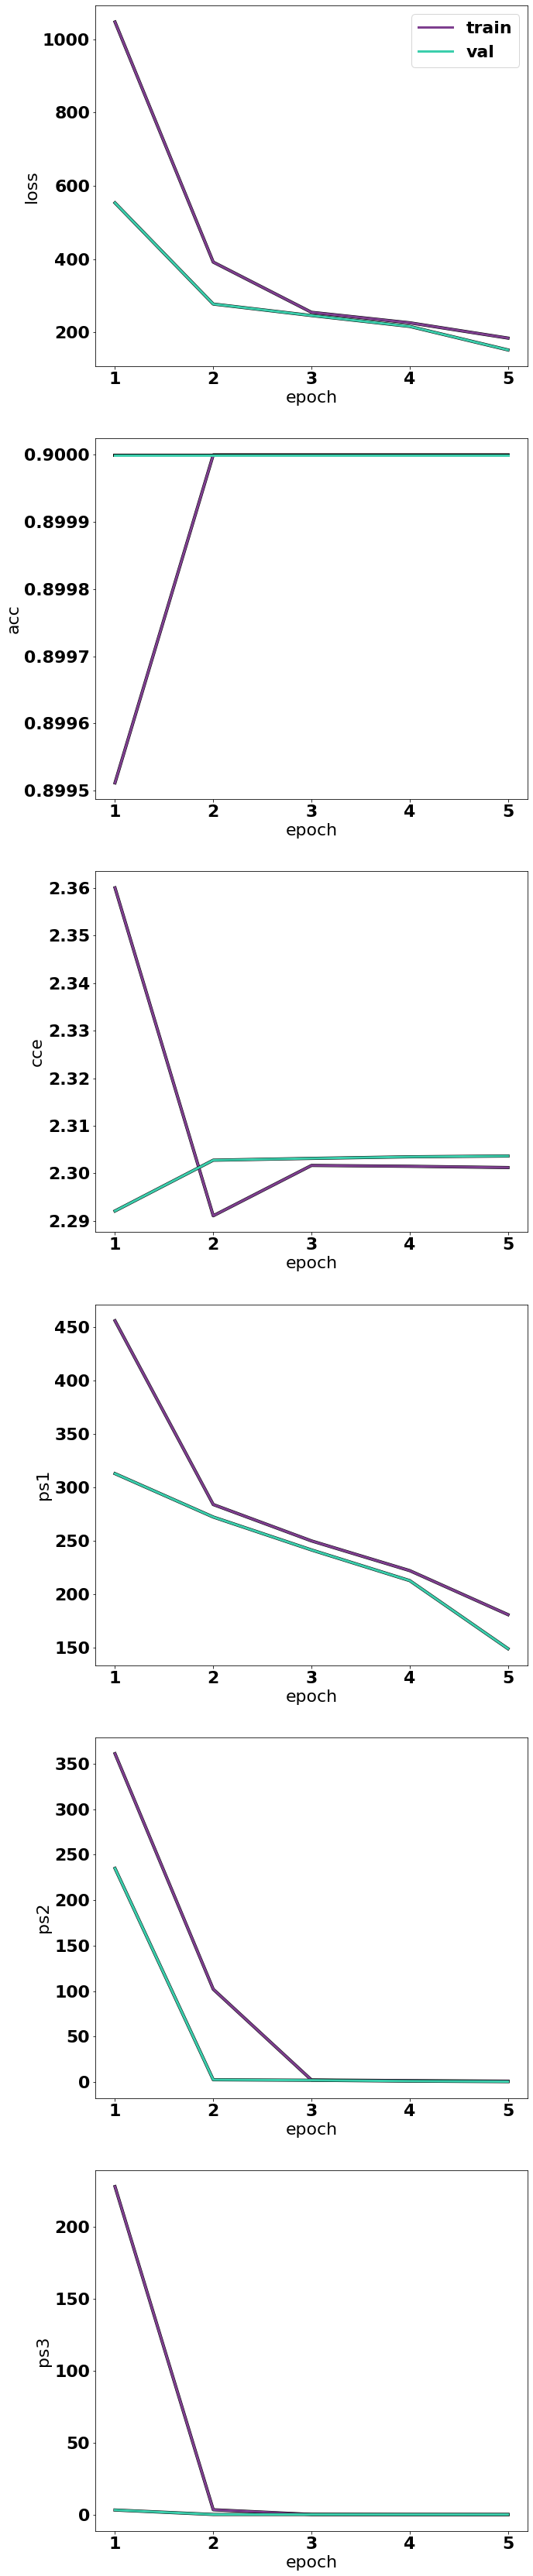

In [15]:
fig = plt.figure(figsize=(10,60))
for j,m in enumerate(['loss', 'acc', 'cce', 'ps1', 'ps2', 'ps3']):
    ax = fig.add_subplot(6,1,j+1)
    ax.plot(range(1,epochs+1), np.squeeze(history.history[m]), 'k-', lw=4)
    t, = ax.plot(range(1,epochs+1), np.squeeze(history.history[m]), '-', color='#7E3F8F', lw=3)
    ax.plot(range(1,epochs+1), np.squeeze(history.history['val_{}'.format(m)]), 'k-', lw=4)
    v, = ax.plot(range(1,epochs+1), np.squeeze(history.history['val_{}'.format(m)]), '-', color='#3BCEAC', lw=3)
    ax.set_ylabel(m)
    ax.set_xlabel('epoch')
    if j == 0:
        ax.legend([t, v], ['train', 'val'])


### calculate test set accuracy

In [16]:
inference = tf.keras.Model(inputs=i, outputs=o)
y_pred_test = inference.predict(np.array(x_test))
print(np.mean(my_acc(y_test, y_pred_test)))

0.9


### calculate activations across the training set

In [17]:
embed = tf.keras.Model(inputs=i, outputs=e3)
model.summary()
embed.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 31, 31, 16)   208         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 30, 30, 32)   2080        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 29, 29, 64)   8256        conv2d_2[0][0]                   
______________________________________________________________________________________________

In [19]:
embed.layers[1].set_weights(model.layers[1].get_weights())
embed.layers[2].set_weights(model.layers[2].get_weights())
embed.layers[3].set_weights(model.layers[3].get_weights())
activations_by_class = {}
a = embed.predict(np.array(x_train))
# print(a.shape)
# print(np.sum(np.sum(a, axis=0), axis=0).shape)
for j in tqdm(range(len(x_train[:limit]))):
    try:
        activations_by_class[np.argmax(y_train, axis=1)[j]] += np.squeeze(np.sum(np.sum(a[j], axis=0), axis=0))
    except KeyError:
        activations_by_class[np.argmax(y_train, axis=1)[j]] = np.squeeze(np.sum(np.sum(a[j], axis=0), axis=0))


100%|██████████████████████████████████████████████████████████████████████| 1024/1024 [00:01<00:00, 930.70it/s]


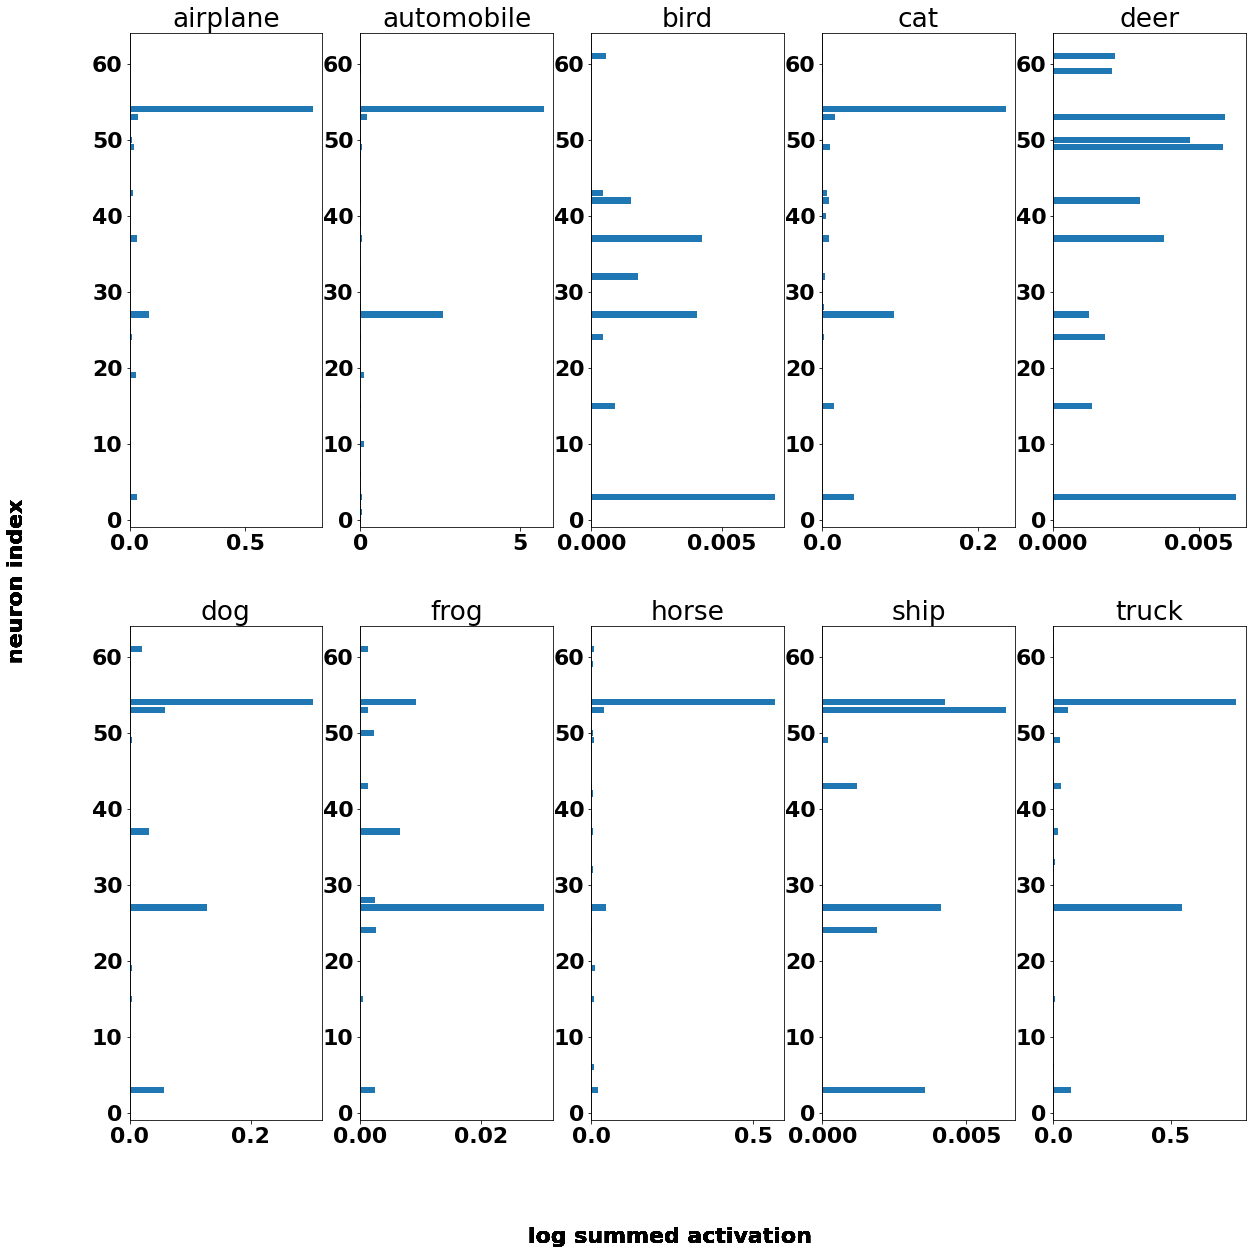

In [22]:
fig = plt.figure(figsize=(20,20))
classes = list(activations_by_class.keys())
classes.sort()
labels = ['airplane',
          'automobile',
          'bird',
          'cat',
          'deer',
          'dog',
          'frog',
          'horse',
          'ship',
          'truck']

for j,k in enumerate(classes):
    y_pos = np.arange(len(activations_by_class[k]))
    ax = fig.add_subplot(2, 5, j+1)
    ax.set_title(labels[k])
    #ax.barh(y_pos, np.log(np.squeeze(activations_by_class[k])), align='center')
    ax.barh(y_pos, np.squeeze(activations_by_class[k]), align='center')
    ax.plot([0,0],[-1,len(np.squeeze(activations_by_class[k]))], 'k-')
    ax.set_ylim(-1,len(np.squeeze(activations_by_class[k])))
    fig.text(0.5, 0.04, 'log summed activation', ha='center')
    fig.text(0.04, 0.5, 'neuron index', va='center', rotation='vertical')

### calculate activations across the test set

In [24]:
activations_by_class_test = {}
a = embed.predict(np.array(x_test))
# print(a.shape)
# print(np.sum(np.sum(a, axis=0), axis=0).shape)
for j in tqdm(range(len(x_test[:test_limit]))):
    try:
        activations_by_class[np.argmax(y_test, axis=1)[j]] += np.squeeze(np.sum(np.sum(a[j], axis=0), axis=0))
    except KeyError:
        activations_by_class[np.argmax(y_test, axis=1)[j]] = np.squeeze(np.sum(np.sum(a[j], axis=0), axis=0))


100%|███████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 4401.15it/s]


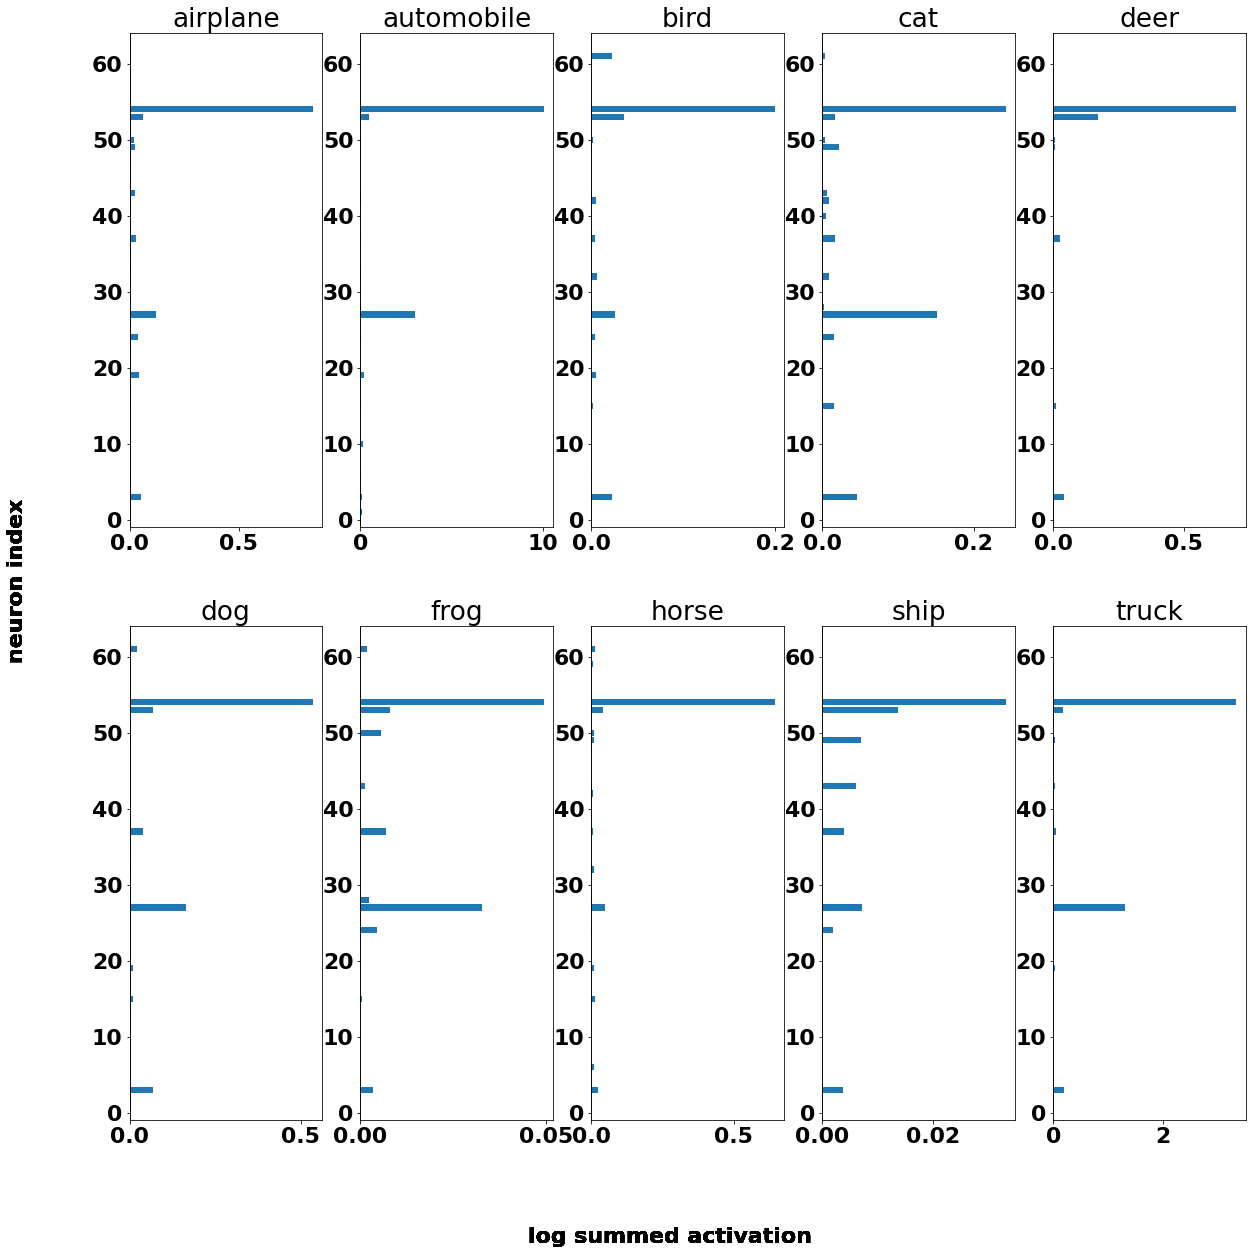

In [26]:
fig = plt.figure(figsize=(20,20))
classes = list(activations_by_class.keys())
classes.sort()
for j,k in enumerate(classes):
    y_pos = np.arange(len(activations_by_class[k]))
    ax = fig.add_subplot(2, 5, j+1)
    ax.set_title(labels[k])
    #ax.barh(y_pos, np.log(np.squeeze(activations_by_class[k])), align='center')
    ax.barh(y_pos, np.squeeze(activations_by_class[k]), align='center')
    ax.plot([0,0],[-1,len(np.squeeze(activations_by_class[k]))], 'k-')
    ax.set_ylim(-1,len(np.squeeze(activations_by_class[k])))
    fig.text(0.5, 0.04, 'log summed activation', ha='center')
    fig.text(0.04, 0.5, 'neuron index', va='center', rotation='vertical')

### measure degree of polysemantism across training set activations

In [27]:
sum = 0
for c in list(itertools.combinations(range(10), 2)):
    a = (np.squeeze(activations_by_class[c[0]]) / (np.max(np.abs(np.squeeze(activations_by_class[c[0]])))) + 1e-9)
    b = (np.squeeze(activations_by_class[c[1]]) / (np.max(np.abs(np.squeeze(activations_by_class[c[1]])))) + 1e-9)
    sum += np.dot(np.transpose(a), b)
print(sum/len(list(itertools.combinations(range(10), 2))))

1.1079545206493802


### measure degree of polysemantism across test set activations

In [29]:
sum = 0
for c in list(itertools.combinations(range(10), 2)):
    a = (np.squeeze(activations_by_class_test[c[0]]) / (np.max(np.abs(np.squeeze(activations_by_class_test[c[0]])))) + 1e-9)
    b = (np.squeeze(activations_by_class_test[c[1]]) / (np.max(np.abs(np.squeeze(activations_by_class_test[c[1]])))) + 1e-9)
    sum += np.dot(np.transpose(a), b)
print(sum/len(list(itertools.combinations(range(10), 2))))

KeyError: 0

### visualise hidden neurons

In [30]:
W = embed.layers[1].get_weights()
print(W[0].shape)
fig = plt.figure(figsize=(20,20))
dim = int(np.ceil(np.sqrt(n_hidden_neurons)))
for j in range(n_hidden_neurons):
    x_j = W[0][:,j] / np.sqrt(np.sum(np.dot(W[0][:,j], W[0][:,j].T)))
    ax = fig.add_subplot(dim,dim,j+1)
    ax.imshow(x_j.reshape((28,28)))
    plt.axis('off')
plt.show()

(2, 2, 3, 16)


ValueError: shapes (2,3,16) and (16,3,2) not aligned: 16 (dim 2) != 3 (dim 1)

<Figure size 1440x1440 with 0 Axes>